# Pre Lab 10: FFT

## Objectives

In this prelab we will learn how to calculate the FFT and extract information from it using functions from `numpy.fft`. We will work with noise from a seismometer, calculate a power spectral density, and apply a low pass filter.

**Warning:** This is a somewhat long prelab. The FFT is very important and there is a lot we want to understand.

## Initialization

As always you should add initialization to the top of your notebook.

In [13]:
import numpy as np
import scipy.integrate as integ
import scipy.special as sf
import scipy.optimize as opt
import scipy.interpolate as interp
import matplotlib.pyplot as plt
import scipy.linalg as la
rng = np.random.default_rng()
import urllib.request
import scipy.signal as signal

## Exploring the FFT

To begin our exploration of the FFT consider a simple signal containing two frequencies written as
$$ h(t) = a_1 \sin(2\pi f_1 t) + a_2 \sin(2\pi f_2 t). $$
Let $a_1 = 1$, $a_2 = 1.5$, $f_1=10\,\mathrm{Hz}$, and $f_2=15\,\mathrm{Hz}$. Here we will sample the signal over a time period of $1\,\mathrm{s}$ at different sample rates.

Sample the signal over a total time interval of 1 second using 41 time steps. Calculate the FFT of this sampled signal and save the result: I will call the Fourier transform of our signal `H`. Next calculate the inverse FFT of `H`. This should reproduce the original signal. Produce a quick plot of the true signal and the one calculated by applying the FFT and then an inverse FFT. [*Note:* We use an odd number of steps because it makes some of the calculations below easier.]

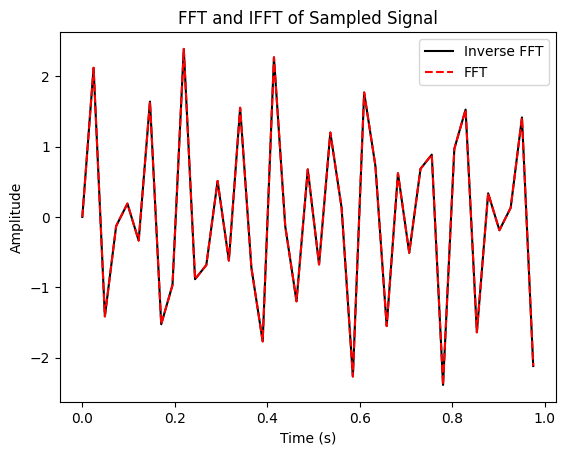

In [14]:
a1 = 1
a2 = 1.5
f1 = 10
f2 = 15

time = 1
steps = 41
dt = time / steps

t = np.arange(0, time, dt)

h = a1 * np.sin(2 * np.pi * f1 * t) + a2 * np.sin(2 * np.pi * f2 * t)

H = np.fft.fft(h)

inv_H = np.fft.ifft(H)

real_fft = inv_H.real

plt.plot(t, real_fft, label='Inverse FFT', color = 'k')
plt.plot(t, h, '--', label='FFT', color = 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('FFT and IFFT of Sampled Signal')
plt.legend()
plt.show()

### Important Note:

You should find the signal from the inverse FFT reproduces the original signal. This is not always the case with FFT implementations! Different implementations of the FFT normalize things in different ways and may require you to renormalize the results. By default the implementation in NumPy does this for you, but others may not. You should always check how the normalization is handled in the library you are using.

### Amplitude

The FFT of our signal should extract the dominant frequencies and their amplitudes. We know what frequencies and amplitudes should appear in our signal. To calculate the frequencies we can use `np.fft.fftfreq`. Note that if you pass the sampling rate to this function it will return the frequencies in the correct units.

Produce a quick plot of the *magnitude of the amplitude* versus the frequency as a line. Do this in the "naive" way using the frequencies directly from `fftfreq`. You should find the plot has some strange looking features in it.

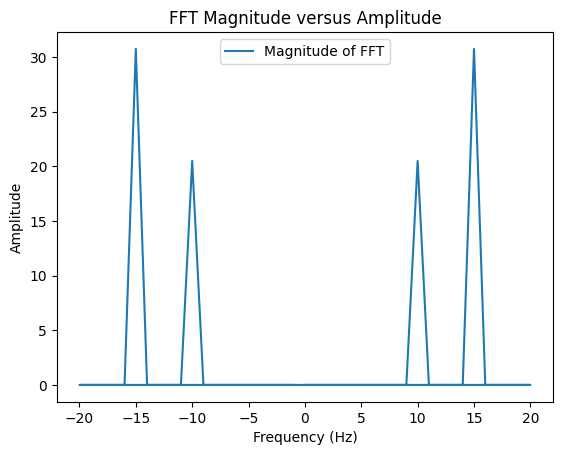

In [15]:
freqs = np.fft.fftfreq(steps, d=dt)

plt.plot(freqs, np.abs(H), label='Magnitude of FFT')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('FFT Magnitude versus Amplitude')
plt.legend()
plt.show()

#### Reorganizing the FFT

There are a number of details to understand when calculating the FFT. First notice that the amplitude in `H` is complex. This is due to the fact that we have used complex exponentials (i.e., complex functions) to represent the sinusoids. Since our signal is real we should really plot the absolute value of the amplitude instead of just the amplitude itself (which is why we plotted the magnitude above). Further, the amplitudes correspond to frequencies in a particular order. As seen in the example for this week the information can be reordered using `np.fft.fftshift`.

Produce a quick plot of the appropriately shifted absolute value of the amplitude versus the also properly shifted frequencies. You should find there are peaks at the frequencies used to construct the signal.

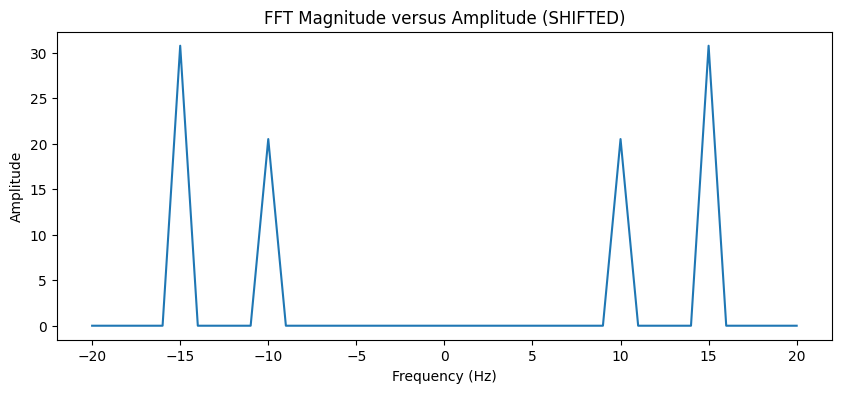

In [16]:
mag_shift = np.fft.fftshift(H)
freq_shift = np.fft.fftshift(freqs)

plt.figure(figsize=(10, 4))
plt.plot(freq_shift, np.abs(mag_shift))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('FFT Magnitude versus Amplitude (SHIFTED)')
plt.show()

As noted above, your plot should only have non-zero amplitudes at the expected frequencies. However, it has non-zero amplitudes at both positive and negative frequencies! These amplitudes are really for the same frequency mode and thus should be combined. Add the absolute values of the positive and negative frequencies. Produce a quick plot of this new amplitude versus the positive frequencies. You can exclude the zero frequency in this calculation and plot.

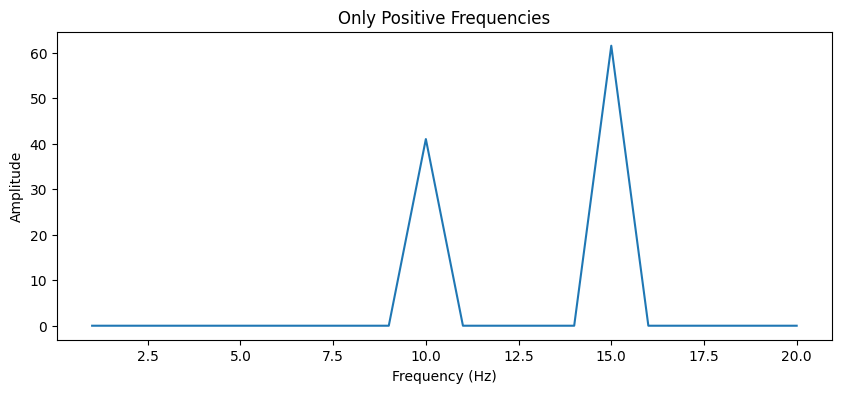

In [17]:
positive_mask = (freqs > 0)
positive_freqs = freqs[positive_mask]

H_mag = np.abs(H)
combined_amplitude = H_mag[positive_mask] + H_mag[positive_mask]

plt.figure(figsize=(10, 4))
plt.plot(positive_freqs, combined_amplitude)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Only Positive Frequencies')
plt.show()


#### Renormalizing the FFT

We should now have found that we only have contributions at the two positive frequencies used to create the signal. The amplitudes we calculated should also equal the amplitudes used to create the signal, but they do not! Why not? Even though calculating the FFT then the inverse FFT does return the normalized result, **the intermediate result is not properly normalized**. 

This was discussed in the example. See the discussion there for details.

Renormalize the amplitude calculated in the previous part. Print the amplitudes at the two frequencies used to calculate the original signal. These should agree with the values used in constructing the signal. Also produce a quick plot of the normalized amplitude versus frequency as in the previous question.

amplitude 1: [1.], a1: 1
amplitude 2: [1.5], a2: 1.5


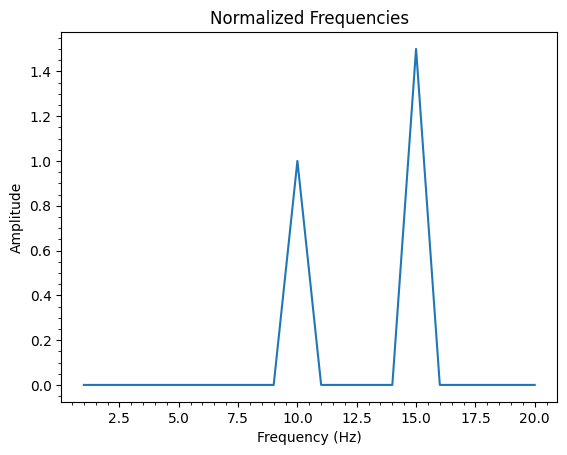

In [18]:
amp_norm = combined_amplitude/steps
plt.plot(positive_freqs, np.abs(amp_norm))

amp_one = np.where(freqs == 10)[0]
amp_two = np.where(freqs == 15)[0]
plt.minorticks_on()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Normalized Frequencies')

print("amplitude 1: {}, a1: {}".format(np.abs(amp_norm[amp_one-1]), a1))
print("amplitude 2: {}, a2: {}".format(np.abs(amp_norm[amp_two-1]), a2))

## Seismic Data

Data in the time domain shows up in many, many places. One example we will explore in more detail in the lab comes from monitoring the seismic activity of the Earth. We will begin by looking at the acceleration measured by a seismometer during "normal" activity, i.e., when nothing interesting is going on, thus, we will be looking at noise.

As with every field there are particular formats used for storing data. Here I have done a bit of preprocessing and stored the data in `TSPAIR` format. This means the first line of the file is a header containing what would be useful information (if we were going to use it) and the rest of the file contains two columns.
* Column 1: Date-Time stamp of when the measurement was made.
* Column 2: Measured acceleration in $\mathrm{m/s^2}$.

If we were professionally working with seismic data we would use tools specific to the field. In this case, [ObsPy](https://docs.obspy.org/) would be a good choice. We will not do so here! (I did use it to put the data in a simpler form for us to process.)

Working with dates and times is more challenging that you might expect. One approach for dealing with data is to use [Pandas](https://pandas.pydata.org/docs/). This works for many, many types of data in many, many formats. It can also deal with dates and times for us. However, it is also a large module with a steep learning curve. So we do not need to do this either.

Next, there is a `datetime` module in the standard python library for this and `matplotlib` can handle plotting `datetime` objects. However, this is a lot of work and is not required. See the end of the prelab for a bit more of a discussion.

For our purposes we can skip all of this and just read in the data file using our standard approaches and ignore the information that causes problems! From the first line of the file all we need to know is that the measurements are collected with a sampling rate of $100\,\mathrm{Hz}$. We can thus just skip the first line of the file when reading it in. Next, we only need the acceleration measurements so we only need to read in the second column from the file.

Read in the acceleration from the url provided below using a `with` statement, similar to the procedure followed last week. We can again use `np.loadtxt`. Remind yourself from the documentation how to
1. Skip the first line of the file
2. Only read in the second column of data (again, you can try to deal with the date time information, but we will be using similar data in the lab and you really do not want to deal with it there).

Read in the data from
`https://raw.githubusercontent.com/cwru-phys-250/resources/main/data/seismic_noise.dat`
and produce a quick plot of the signal. (Plotting versus index number is sufficient, we just want to see what it looks like.)

In [19]:
url = "https://raw.githubusercontent.com/cwru-phys-250/resources/main/data/seismic_noise.dat"
with urllib.request.urlopen(url) as fp:
    seismic = np.loadtxt(fp, usecols=1, skiprows=1, unpack=True)

sampling_rate = 100 #Hz


### Power Spectral Density

As noted in the lecture, the power spectral density (PSD) and related terms are used to mean similar things in different contexts. The precise definition must be checked with care. Let $n(t)$ represent our noise signal sampled at the rate $f_s$. Here we will define the one-sided PSD for $0 < f < f_s/2$. (Notice that this *does not include* $f=0$ nor the Nyquist frequency. Typically we *will actually include* the Nyquist frequency since we also typically filter it out, as we will do below. Thus, you do not need to remove the Nyquist frequency.) One definition that will be useful to us when we want to normalize a signal based on its noise properties is
$$ \mathrm{PSD} \equiv \frac{|\tilde{n}(f)|^2 + |\tilde{n}(-f)|^2}{N f_s}, $$
where $\tilde{n}(f)$ is the Fourier transform of $n(t)$ and $N$ is the total number of samples of the signal. Since our signal $n(t)$ is real the negative frequency amplitudes are related to the positive frequency amplitudes as $\tilde{n}(-f) = [\tilde{n}(f)]^*$, thus you will typically see this version of the PSD written as
$$ \mathrm{PSD} \equiv \frac{2|\tilde{n}(f)|^2}{N f_s}, $$
where only the positive frequency amplitudes are used. (Technically this definition is assuming no window function. We could include a window function which would change the $N$ in the denominator. That is more than we need, see more advanced signal processing for further discussions.)

Write a function to calculate a PSD given the signal and its sampling rate. Since our signal is real this can be done either using the FFT functions, `np.fft.fft`, *etc*., or their real equivalents, `np.fft.rfft`, *etc*. We will be doing more processing of real signals in the lab and it usually simpler to use a real FFT, so **I encourage you to use `np.fft.rfft`**. We will be handling similar signals in the lab and I find it easier to work with a real FFT in such cases. However, either the full or real FFT functions can be made to work so you are free to choose.

In [20]:
def calculate_psd(signal, sampling_rate):
    """
    Params:
        signal: 
        sampling_rate: 
    Returns:
        Power Signal Display
    """
    signal_fft = np.fft.rfft(signal)[1:]
    num = 2 * (np.abs(signal_fft)**2)
    N = len(signal)
    denom = N * sampling_rate
    psd = num/denom
    return psd

This definition of the PSD is normalized such that the area under the PSD is equal to the variance in the signal. This means that
$$ \int_{0}^{f_s/2} \mathrm{PSD}(f) \, \mathrm{d}f \approx \sum_f \mathrm{PSD}(f) \Delta f = \mathrm{var}(n(t)). $$
Calculate (and store) the PSD and the frequencies at which it is evaluated. Calculate the integral of the PSD and the variance of the noise signal (of course there is a NumPy function that calculates the variance) and show that they are the same.

(Notice that we have approximated the area under the PSD curve using the Riemann sum. We are doing this despite knowing much more sophisticated algorithms for numerically evaluating integrals. Using the Riemann sum is a perfectly good algorithm in this case. In fact, you could argue that it is *the correct algorithm to use*. You should think about why.)

In [21]:
duration = len(seismic)
N = int(duration * sampling_rate)
frequencys = np.fft.rfftfreq(duration, d=1/sampling_rate)

psd = calculate_psd(seismic, sampling_rate)

delta_f = np.diff(frequencys)[0]
psd_integral = np.sum(psd * delta_f)

signal_variance = np.var(seismic)

print(f"PSD Riemann sum: {psd_integral}")
print(f"Signal Variance: {signal_variance}")

PSD Riemann sum: 1.346941397127576e-07
Signal Variance: 1.3466298182050436e-07


The units of the PSD we have defined are the square of the units of the signal divided by the units of the sampling rate. In our case this means acceleration squared per Hertz. Produce a nice plot of the PSD.

Text(0.5, 1.0, 'Power of PSD versus Frequency')

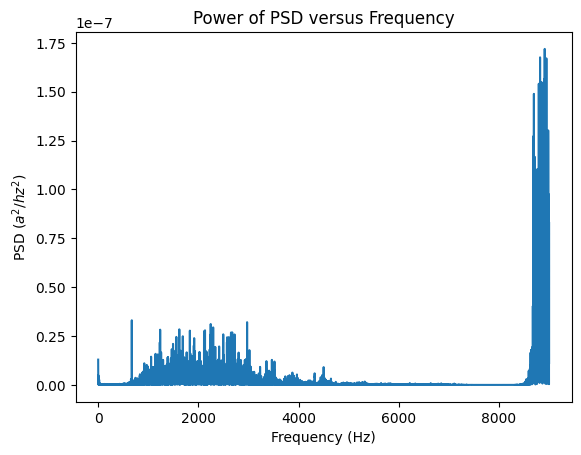

In [22]:
plt.plot(psd)
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"PSD ($a^2 / hz^2$)")
plt.title("Power of PSD versus Frequency")

### Low Pass Filter

You should see that there is a peak at high frequency, right up to the Nyquist frequency. This is clearly noise of a different nature from the lower frequency noise and is injecting a fair bit of power into the signal. Suppose we want to remove this. To do so we can use a low pass filter, i.e., a filter that only lets the low frequencies through. This is simple to do in the frequency domain: just set the amplitude of the high frequency modes to zero. In other words, let $f_{\mathrm{cut}}$ be some frequency cutoff. Set all values of $\tilde{n}(f)$ to zero for $f > f_{\mathrm{cut}}$. If we now calculate the inverse Fourier transform of this modified $\tilde{n}(f)$ we will have a new signal $n'(t)$ that does not contain the high frequency contributions.

Choose some value for $f_{\mathrm{cut}}$ and filter the noise. Produce a nice plot of the original and filtered signals. Plot the time on the $x$-axis in seconds.

Choose a value for $f_{\mathrm{cut}}$ near where the amplitude of the high frequency noise becomes small. We are going to apply a similar filter in the lab and do not want to cut out any real signals.

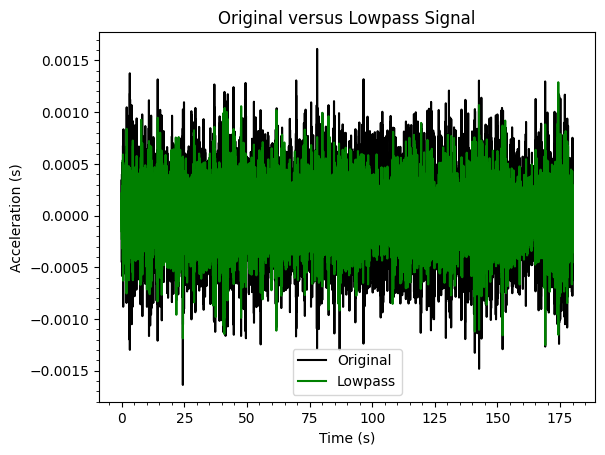

In [23]:
f_cut = 40

ix = np.where(frequencys >= f_cut)
ntilde = np.fft.rfft(seismic)
ntilde[ix] = 0
nprime = np.fft.irfft(ntilde)

times = np.linspace(0, duration/sampling_rate,duration)

plt.plot(times, seismic, color = 'k', label = 'Original')
plt.plot(times, nprime, color = 'g', label = 'Lowpass')
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (s)")
plt.title("Original versus Lowpass Signal")
plt.minorticks_on()

## Dates and Times

The prelab is completed, however, if you would like to know about dealing with dates and times read on.

As noted above, dates and times are challenging to deal with computationally. There are so many different ways in which they are written and stored. For example, what date is 02/05/20? Is this mm/dd/yy or dd/mm/yy and is the year 1920, 2020, ....? In addition to this, if I tell you the prelab is due at 8:00 AM, in what timezone am I setting the time? (Yes, Canvas handles timezones correctly, so, yes, this means in the local timezone, and, no, this is not a loop hole you can exploit!) When specifying times and dates a consistent and coherent convention must be used. Fortunately there are standards. Unfortunately there are standards, plural.

Timezones make things even more complicated. Daylight savings time (or really daylight ruining time) makes things worse as it ties the time and timezone to the date. Thus, if you want to know how much time it is until some event on some date in some location you need to know the time it is now in your location in your local timezone and compare it to the time at the location of the event which may be in a different timezone and may or may not be corrected for a daylight savings shift. To deal with this the correct thing to do is convert everything to Coordinated Universal Time (abbreviated UTC). This is a consistent date-time that does not have shifts due to daylight savings. (I will not go into leap seconds, that is a whole different issue.) Intelligent systems store times in UTC and then shift to any other timezone, as needed. (At least one very poorly designed operating system stores the time in your local timezone instead of UTC. I cannot even begin to imagine how anyone thought that was an idea, let alone a good idea.)

The seismic data we are using stores times in UTC, as it should. Further, the first column of the data file is in a standard format, so can easily be parsed (by both humans and the computer). The `datetime` module in Python can convert it to a `datetime` object which can then be manipulated. NumPy also has the `np.datetime64` type which is understood by `matplotlib` and can be used for plotting. Unfortunately, `np.datetime64` does not handle timezones. Thus, if we really want to do things ourselves, we should read in the date-times into Python, do whatever manipulations we want, then convert them to `np.datetime64` for further processing. Alternatively, just use Pandas and let it deal these issues!

The solutions will contain an example of how this could be done. It is not quite as bad as it may sound since the date-time format used in the data file is in the ISO 8061 standard, which `datetime` already knows how to parse.

In [24]:
# The solutions will contain the time stamp handling code here.